# Advanced ML

## Bayesian Changepoint Analysis (CPA)

Consider the following time series of recorded coal mining disasters in the UK from 1851 to 1962 (Jarrett, 1979). The number of disasters is thought to have been affected by changes in safety regulations during this period. 

Unfortunately, we also have pair of years with missing data, identified as missing by a nan in the pandas Series. These missing values will be automatically imputed by PyMC3.

We will build a model for this series and attempt to estimate when the change occurred. At the same time, we will see how to handle missing data, use multiple samplers and sample from discrete random variables.

https://docs.pymc.io/notebooks/getting_started.html?highlight=coal#Case-study-2:-Coal-mining-disasters

In [1]:
import os
os.environ["MKL_THREADING_LAYER"] = "GNU"

In [50]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pymc3 as pm
from pymc3 import Metropolis, NUTS, sample, traceplot

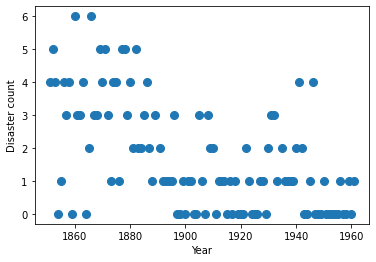

In [58]:
import pandas as pd
disaster_data = pd.Series([4, 5, 4, 0, 1, 4, 3, 4, 0, 6, 3, 3, 4, 0, 2, 6,
                           3, 3, 5, 4, 5, 3, 1, 4, 4, 1, 5, 5, 3, 4, 2, 5,
                           2, 2, 3, 4, 2, 1, 3, np.nan, 2, 1, 1, 1, 1, 3, 0, 0,
                           1, 0, 1, 1, 0, 0, 3, 1, 0, 3, 2, 2, 0, 1, 1, 1,
                           0, 1, 0, 1, 0, 0, 0, 2, 1, 0, 0, 0, 1, 1, 0, 2,
                           3, 3, 1, np.nan, 2, 1, 1, 1, 1, 2, 4, 2, 0, 0, 1, 4,
                           0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1])
years = np.arange(1851, 1962)

plt.plot(years, disaster_data, 'o', markersize=8);
plt.ylabel("Disaster count")
plt.xlabel("Year");

Occurrences of disasters in the time series is thought to follow a Poisson process with a large rate parameter in the early part of the time series, and from one with a smaller rate in the later part. We are interested in locating the change point in the series, which perhaps is related to changes in mining safety regulations.

The parameters are defined as follows: 

* $D_t$: The number of disasters in year $t * r_t$. The rate parameter of the Poisson distribution of disasters in year t. 
* $s$: The year in which the rate parameter changes (the switchpoint). 
* $e$: The rate parameter before the switchpoint s. 
* $l$: The rate parameter after the switchpoint s. 
* $t_l, t_h$: The lower and upper boundaries of year t.

$$\begin{split}\begin{aligned}
  D_t &\sim \text{Pois}(r_t), r_t= \begin{cases}
   e, & \text{if } t \le s \\
   l, & \text{if } t \gt s
   \end{cases} \\
  s &\sim \text{Unif}(t_l, t_h)\\
  e &\sim \text{exp}(1)\\
  l &\sim \text{exp}(1)
\end{aligned}\end{split}$$

Missing values are handled transparently by passing a MaskedArray or a pandas.DataFrame with NaN values to the observed argument when creating an observed stochastic random variable. Behind the scenes, another random variable, disasters.missing_values is created to model the missing values.

### Model

In [59]:
with pm.Model() as disaster_model:

    # Non informative prior
    switchpoint = pm.DiscreteUniform('switchpoint', lower=years.min(), upper=years.max(), testval=1900)

    # Priors for pre- and post-switch rates number of disasters
    # Exponential counting function always positive
    early_rate = pm.Exponential('early_rate', 1)
    late_rate = pm.Exponential('late_rate', 1)

    # Allocate appropriate Poisson rates to years before and after current
    # Switch Theano function works like an if statement. 
    # It uses the first argument to switch between the next two arguments.
    rate = pm.math.switch(switchpoint >= years, early_rate, late_rate)
    
    #likelihood function
    disasters = pm.Poisson('disasters', rate, observed=disaster_data)

c:\apps\anaconda3\lib\site-packages\pymc3\model.py:1430: ImputationWarning: Data in disasters contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)


In [66]:
# Method 1 - automated
with disaster_model:
    trace = pm.sample(10000)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>CompoundStep
>>Metropolis: [disasters_missing]
>>Metropolis: [switchpoint]
>NUTS: [late_rate, early_rate]
Sampling 4 chains, 0 divergences: 100%|█████████████████████████████████████████████████████████████████████████| 42000/42000 [00:27<00:00, 1530.54draws/s]
The number of effective samples is smaller than 10% for some parameters.


Unfortunately because they are discrete variables and thus have no meaningful gradient, we cannot use NUTS for sampling switchpoint or the missing disaster observations. Instead, we will sample using a Metropolis step method, which implements adaptive Metropolis-Hastings, because it is designed to handle discrete values. PyMC3 automatically assigns the correct sampling algorithms.

In [60]:
# Method 2 - NUTS, Metropolis added to the mix
with disaster_model:
    step1 = NUTS([early_rate, late_rate])

    # Use Metropolis for switchpoint, and missing values since it accommodates discrete variables
    step2 = Metropolis([switchpoint, disasters.missing_values[0]] )

    trace = sample(10000, step=[step1, step2])

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [late_rate, early_rate]
>CompoundStep
>>Metropolis: [disasters_missing]
>>Metropolis: [switchpoint]
Sampling 4 chains, 0 divergences: 100%|█████████████████████████████████████████████████████████████████████████| 42000/42000 [00:33<00:00, 1260.03draws/s]
The number of effective samples is smaller than 10% for some parameters.


### Results

In the trace plot below we can see that there’s about a 10 year span that’s plausible for a significant change in safety, but a 5 year span that contains most of the probability mass. The distribution is jagged because of the jumpy relationship between the year switchpoint and the likelihood and not due to sampling error.

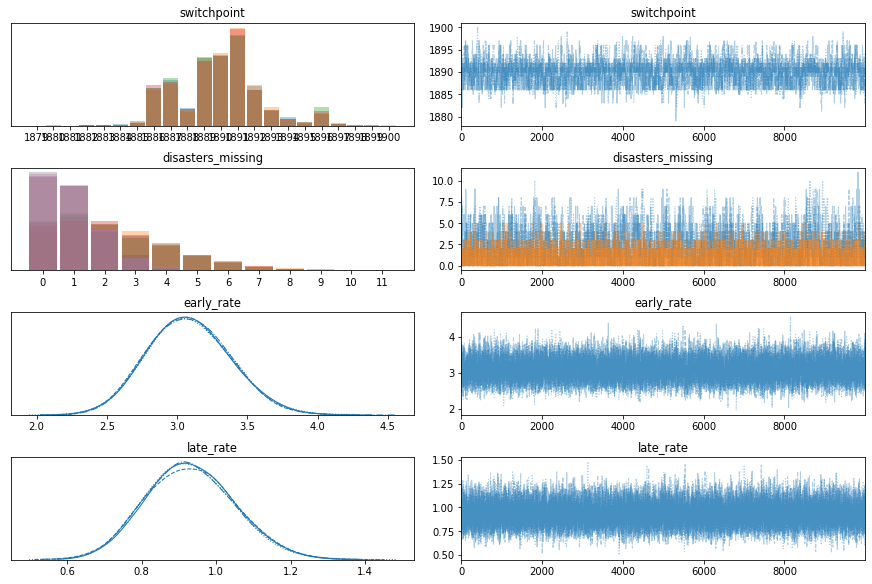

In [67]:
pm.traceplot(trace);

### Visualize Switchpoint

The following plot shows the switch point as an orange vertical line, together with its HPD as a semitransparent band. The dashed black line shows the accident rate.

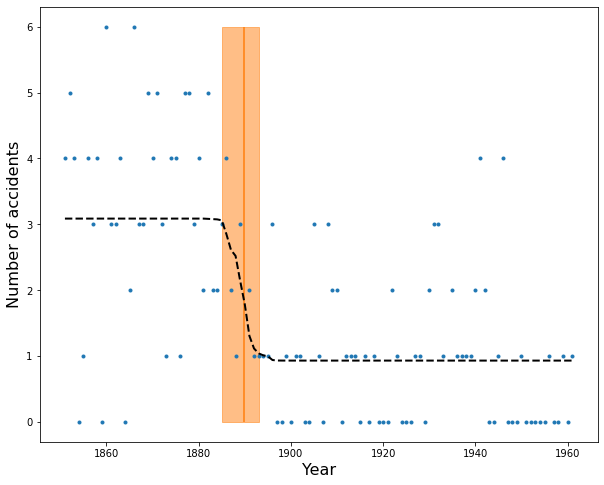

In [64]:
plt.figure(figsize=(10, 8))
plt.plot(years, disaster_data, '.')
plt.ylabel("Number of accidents", fontsize=16)
plt.xlabel("Year", fontsize=16)

plt.vlines(trace['switchpoint'].mean(), disaster_data.min(), disaster_data.max(), color='C1')
average_disasters = np.zeros_like(disaster_data, dtype='float')
for i, year in enumerate(years):
    idx = year < trace['switchpoint']
    average_disasters[i] = (trace['early_rate'][idx].sum() + trace['late_rate'][~idx].sum()) / (len(trace) * trace.nchains)

sp_hpd = pm.hpd(trace['switchpoint'])
plt.fill_betweenx(y=[disaster_data.min(), disaster_data.max()],
                  x1=sp_hpd[0], x2=sp_hpd[1], alpha=0.5, color='C1');
plt.plot(years, average_disasters,  'k--', lw=2);

In [63]:
pm.summary(trace).round(2)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
switchpoint,1889.77,2.40,1885.00,1893.00,0.06,0.04,1598.0,1598.0,1612.0,2430.0,1.0
disasters_missing[0],2.10,1.79,0.00,5.00,0.05,0.03,1353.0,1353.0,1396.0,2468.0,1.0
disasters_missing[1],0.94,0.96,0.00,3.00,0.01,0.01,4509.0,4420.0,4658.0,5715.0,1.0
early_rate,3.09,0.29,2.54,3.62,0.00,0.00,17395.0,17395.0,17249.0,23284.0,1.0
late_rate,0.93,0.12,0.71,1.16,0.00,0.00,18528.0,18528.0,18467.0,24658.0,1.0
